# Vehicle Detection Tutorial

### Support Vector Machine vs YOLO V2

In [1]:
# Util libraries
import cv2
import os, fnmatch
import numpy as np
import time
import itertools

#  SVC and YOLO classifier
from utils import SupportVectorMachineClassifier, YOLOV2

# Helper functions
from sklearn.preprocessing import StandardScaler
from utils import get_feature, extract_feature

# Visualiztion
import matplotlib.pyplot as plt
%matplotlib inline

## Import Dataset

In [2]:
# Get list of filenames
def get_file_names(src_path='./', pattern='*.jpeg'):
    # Return a list of file names in a given folder with certain pattern
    images = []
    for root, dir_names, file_names in os.walk(src_path):
        for filename in fnmatch.filter(file_names, pattern):
            images.append(os.path.join(root, filename))
    return images

In [3]:
# Import car and not car images
cars = get_file_names('./data/vehicles', pattern='*.png')
not_cars = get_file_names('./data/non-vehicles', pattern='*.png')
print("Car Images :{} images\nNot Car Images: {} images".format(len(cars),len(not_cars)))

Car Images :8792 images
Not Car Images: 8968 images


## Data Exploration

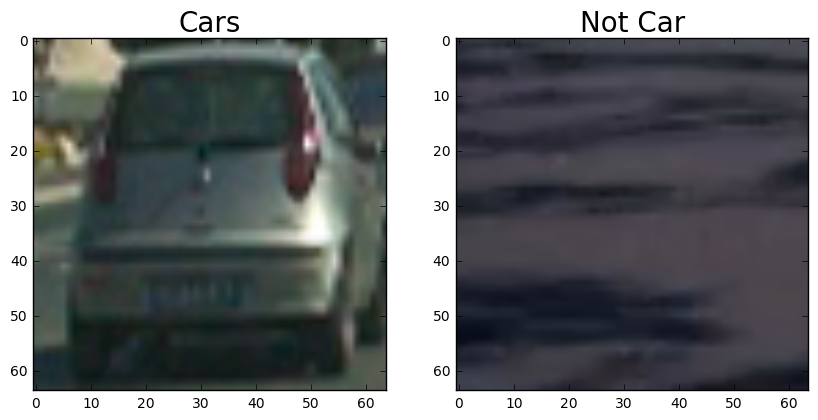

In [4]:
# Data Exploration
idx = np.random.randint(0, len(cars))
a, fg = plt.subplots(1,2, figsize=(10, 5))
fg[0].imshow(cv2.cvtColor(cv2.imread(cars[idx]),cv2.COLOR_BGR2RGB))
fg[0].set_title("Cars", fontsize=20)
fg[1].imshow(cv2.cvtColor(cv2.imread(not_cars[idx]),cv2.COLOR_BGR2RGB))
fg[1].set_title("Not Car", fontsize=20)

### Extract Feature Vector for Car and Not-Car Images

In [5]:
# Calculate car features & not-car features
t = time.time()
# Workers for parallel multi processing, please change based on your CPU.
print("Calculating Car Feature Vector on {} images".format(len(cars)))
car_features = get_feature(cars, workers=4)
print("Calculating Not-Car Feature Vector on {} images".format(len(not_cars)))
not_car_features = get_feature(not_cars, workers=4)
print("Completed calculating feature in {:f} seconds\n".format((time.time() - t), 3))

Calculating Car Feature Vector on 8792 images
Average time / feature : 0.002970280757917937 seconds
Max Value 1.0 Min Value 0.03529411764705882

Calculating Not-Car Feature Vector on 8968 images
Average time / feature : 0.002593412317408716 seconds
Max Value 0.9019607843137255 Min Value 0.2627450980392157

Completed calculating feature in 13.190219 seconds



Feature length:  8460


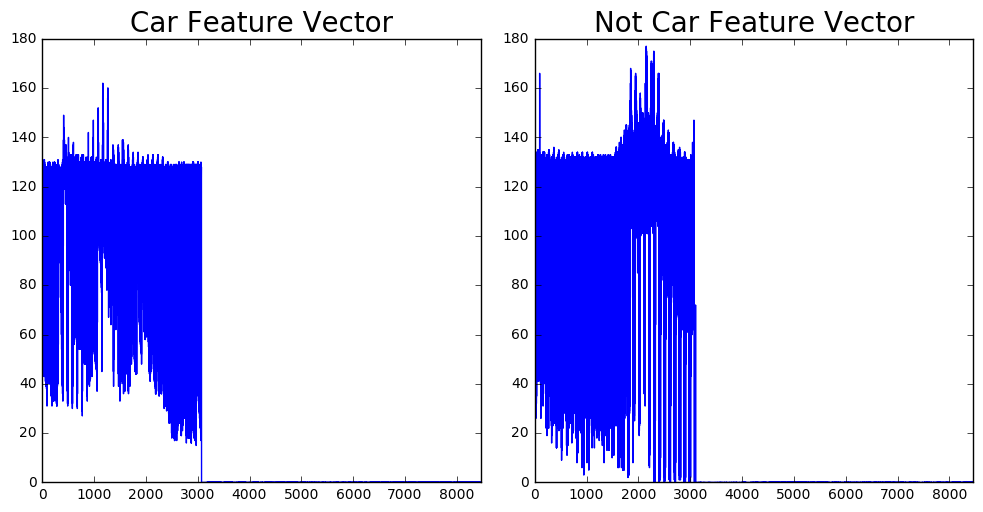

In [6]:
idx = np.random.randint(0, len(cars))
print("Feature length: ", len(car_features[idx]))
saved_unormalized = car_features[idx] # To compare between unormalized and normalized
a, fg = plt.subplots(1,2, figsize=(10, 5))
a.tight_layout()
fg[0].plot(car_features[idx])
fg[0].set_xlim([0,len(car_features[idx])])
fg[0].set_title("Car Feature Vector", fontsize=20)

fg[1].plot(not_car_features[idx])
fg[1].set_xlim([0,len(car_features[idx])])
fg[1].set_title("Not Car Feature Vector", fontsize=20)

### Normalize feature vector using StandardScaler()

In [7]:
from sklearn.model_selection import train_test_split

# Create data set
x = np.vstack((car_features, not_car_features)).astype(np.float64)
y = np.concatenate((np.ones(len(car_features)), np.zeros(len(not_car_features))))

print("Training feature vector's size", x.shape)

# Apply Standard Scalars to normalize vector 
X_scaler = StandardScaler().fit(x)
scaled_x = X_scaler.transform(x)

random_state = np.random.randint(0, 100)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=random_state)
print("Training data: Features {}, Labels {}".format(len(x_train), len(y_train)))
print("Test data: Features {}, Labels {}".format(len(x_test), len(y_test)))

Training feature vector's size (17760, 8460)
Training data: Features 14208, Labels 14208
Test data: Features 3552, Labels 3552


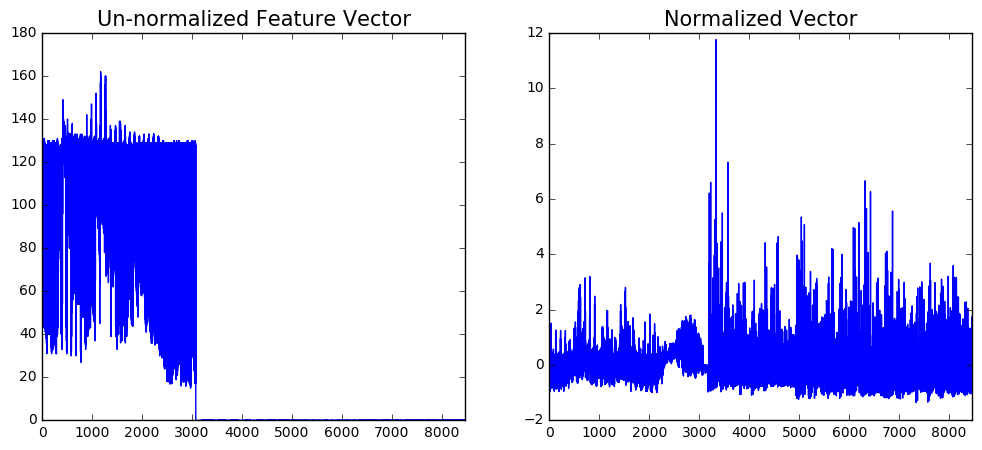

In [8]:
idx = np.random.randint(0, len(cars))
a, fg = plt.subplots(1,2, figsize=(12, 5))
fg[0].plot(saved_unormalized)
fg[0].set_xlim([0,len(x[idx])])
fg[0].set_title("Un-normalized Feature Vector", fontsize=15)
fg[1].plot(scaled_x[idx])
fg[1].set_xlim([0,len(x[idx])])
fg[1].set_title("Normalized Vector", fontsize=15)

### Build SVC Classifier and YOLO-V2 Classifier

In [9]:
# Build YOLO-V2 Classifier - I am using pre-trained model  on darkflow
yolo = YOLOV2(cfg_path="cfg/tiny-yolo-voc.cfg", weight_path="bin/tiny-yolo-voc.weights")
# yolo = YOLOV2(cfg_path="cfg/yolo-voc.cfg", weight_path="bin/yolo-voc.weights")

Parsing ./cfg/tiny-yolo-voc.cfg
Parsing cfg/tiny-yolo-voc.cfg
Loading bin/tiny-yolo-voc.weights ...
Successfully identified 63471556 bytes
Finished in 0.0040934085845947266s


In [10]:
# Build SVC Classifier and train it
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

svc = Pipeline([('scaling', StandardScaler()), ('classification', LinearSVC(loss='hinge')),])
# Apply Standard Scalars to normalize vector
t = time.time()
svc.fit(x_train, y_train)
print("Completed Training in {:2.3f} seconds".format(time.time() - t))

# Test on testing set
score = svc.score(x_test, y_test)
print("Accuracy {:3f}%".format(score))


Completed Training in 7.767 seconds
Accuracy 0.990991%


## Sliding Window and Search Window to detect cars in image for SVC

In [11]:
# Create a list of windows for SVC to select a region of image and compare with the feature vector
def slide_window(img_size, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """Returns all windows to search in an image.
    No classification has been done at this stage.
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_size[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] =  img_size[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1

    # Initialize a list to append window positions to
    window_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, boxes, color=(0, 0, 255), thickness=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    for box in boxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thickness)
    return draw_img

((1216, 656), (1280, 720))


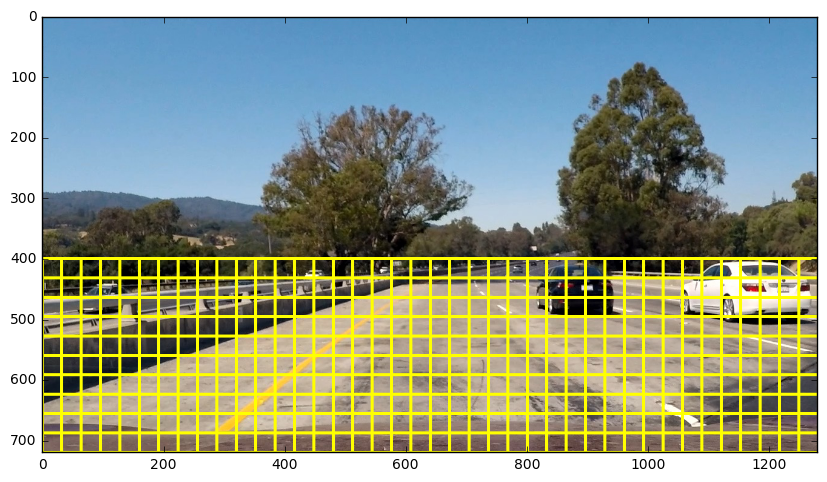

In [12]:
import itertools

test_img = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
img_size = test_img.shape[:2]
windows = slide_window(img_size, x_start_stop=[None, None], y_start_stop=[400, 720],
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
print(windows[-1])


draw_img = draw_boxes(test_img, windows, color=(255, 255, 0), thickness=4)
a = plt.figure( figsize =(10, 20))
plt.imshow(draw_img)


In [13]:
def search_windows(frame, windows, clf, size=(64, 64), decision_threshold=0.3):
    on_windows = []
    for window in windows:
        # Get a region of an image
        region = cv2.resize(frame[window[0][1]:window[1][1], window[0][0]:window[1][0]], size)
        
        # Extract feature of mini image
        region_feature = np.concatenate(extract_feature(region))
        region_feature = region_feature.astype(np.float64).reshape(1,-1)
    
        # Pedict using your classifier
        dec = clf.decision_function(region_feature)
        prediction = int(dec > decision_threshold)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            #rint"Found it!"
            on_windows.append(window)
    return on_windows

def visualize(imgs):
    for img in imgs:
        a = plt.figure(figsize =(15,10))
        plt.imshow(img)

## Main Pipeline : SVC vs YOLO v2 Prediction on Test Images

### Added Heat Map to remove False Positive

In [34]:
import glob
dec_thresh = 0.75
window_size = (96, 96)
x_region = [None, None]
y_region = [400, None]
over_lap = (0.7, 0.7)
windows = slide_window(img_size, x_start_stop=x_region, y_start_stop=y_region,
                        xy_window=window_size, xy_overlap=over_lap)
print("SVC Using: {} windows at size {}, overlap {}".format(len(windows), window_size, over_lap))


svc_results = []
yolo_results = []
heatmap_results = []
svc_avg_time = []
yolo_avg_time = []
for img in glob.glob('./test_images/*.jpg'):
    frame = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    svc_frame = frame.astype(np.float32)
    svc_img = np.copy(frame)
    yolo_img = np.copy(frame)
    
    # Make a heat map of zero
    heatmap = np.zeros_like(svc_img[:, : ,0])
    
    # TEST SVC CLASSIFIER
    start = time.time()
    positive_windows = search_windows(svc_frame , windows, clf=svc, size=(64,64),decision_threshold=dec_thresh)
    svc_avg_time.append(time.time()-start)

    # TEST YOLOV2 CLASSIFIER
    start = time.time()
    windows = yolo.predict(frame)
    yolo_avg_time.append(time.time()-start)
        
    print("SVC Found: {} results".format(len(positive_windows)))
    print("YOLO Found: {} results\n".format(len(windows)))

    for p1, p2 in itertools.chain(positive_windows):
        # Draw SVC boxes
        cv2.rectangle(svc_img, p1, p2, (0,255,0), 4)  
        # Update Heatmap
        heatmap[p1[1]:p2[1], p1[0]:p2[0]] +=50
        
    # Draw YOLO boxes
    yolo_img = draw_boxes(yolo_img, windows)
    heatmap=np.dstack((heatmap, heatmap, heatmap))
    svc_results.append(svc_img)
    yolo_results.append(yolo_img)
    heatmap_results.append(heatmap)
print("SVC Average processing time per img, {} seconds ".format(np.round(np.mean(svc_avg_time),4)))
print("YOLO Average processing time per img, {} seconds ".format(np.round(np.mean(yolo_avg_time),4)))

SVC Using: 440 windows at size (96, 96), overlap (0.7, 0.7)
SVC Found: 8 results
YOLO Found: 0 results

SVC Found: 0 results
YOLO Found: 2 results

SVC Found: 2 results
YOLO Found: 1 results

SVC Found: 0 results
YOLO Found: 1 results

SVC Found: 1 results
YOLO Found: 1 results

SVC Found: 0 results
YOLO Found: 1 results

SVC Found: 0 results
YOLO Found: 0 results

SVC Found: 0 results
YOLO Found: 1 results

SVC Average processing time per img, 0.1385 seconds 
YOLO Average processing time per img, 0.1918 seconds 


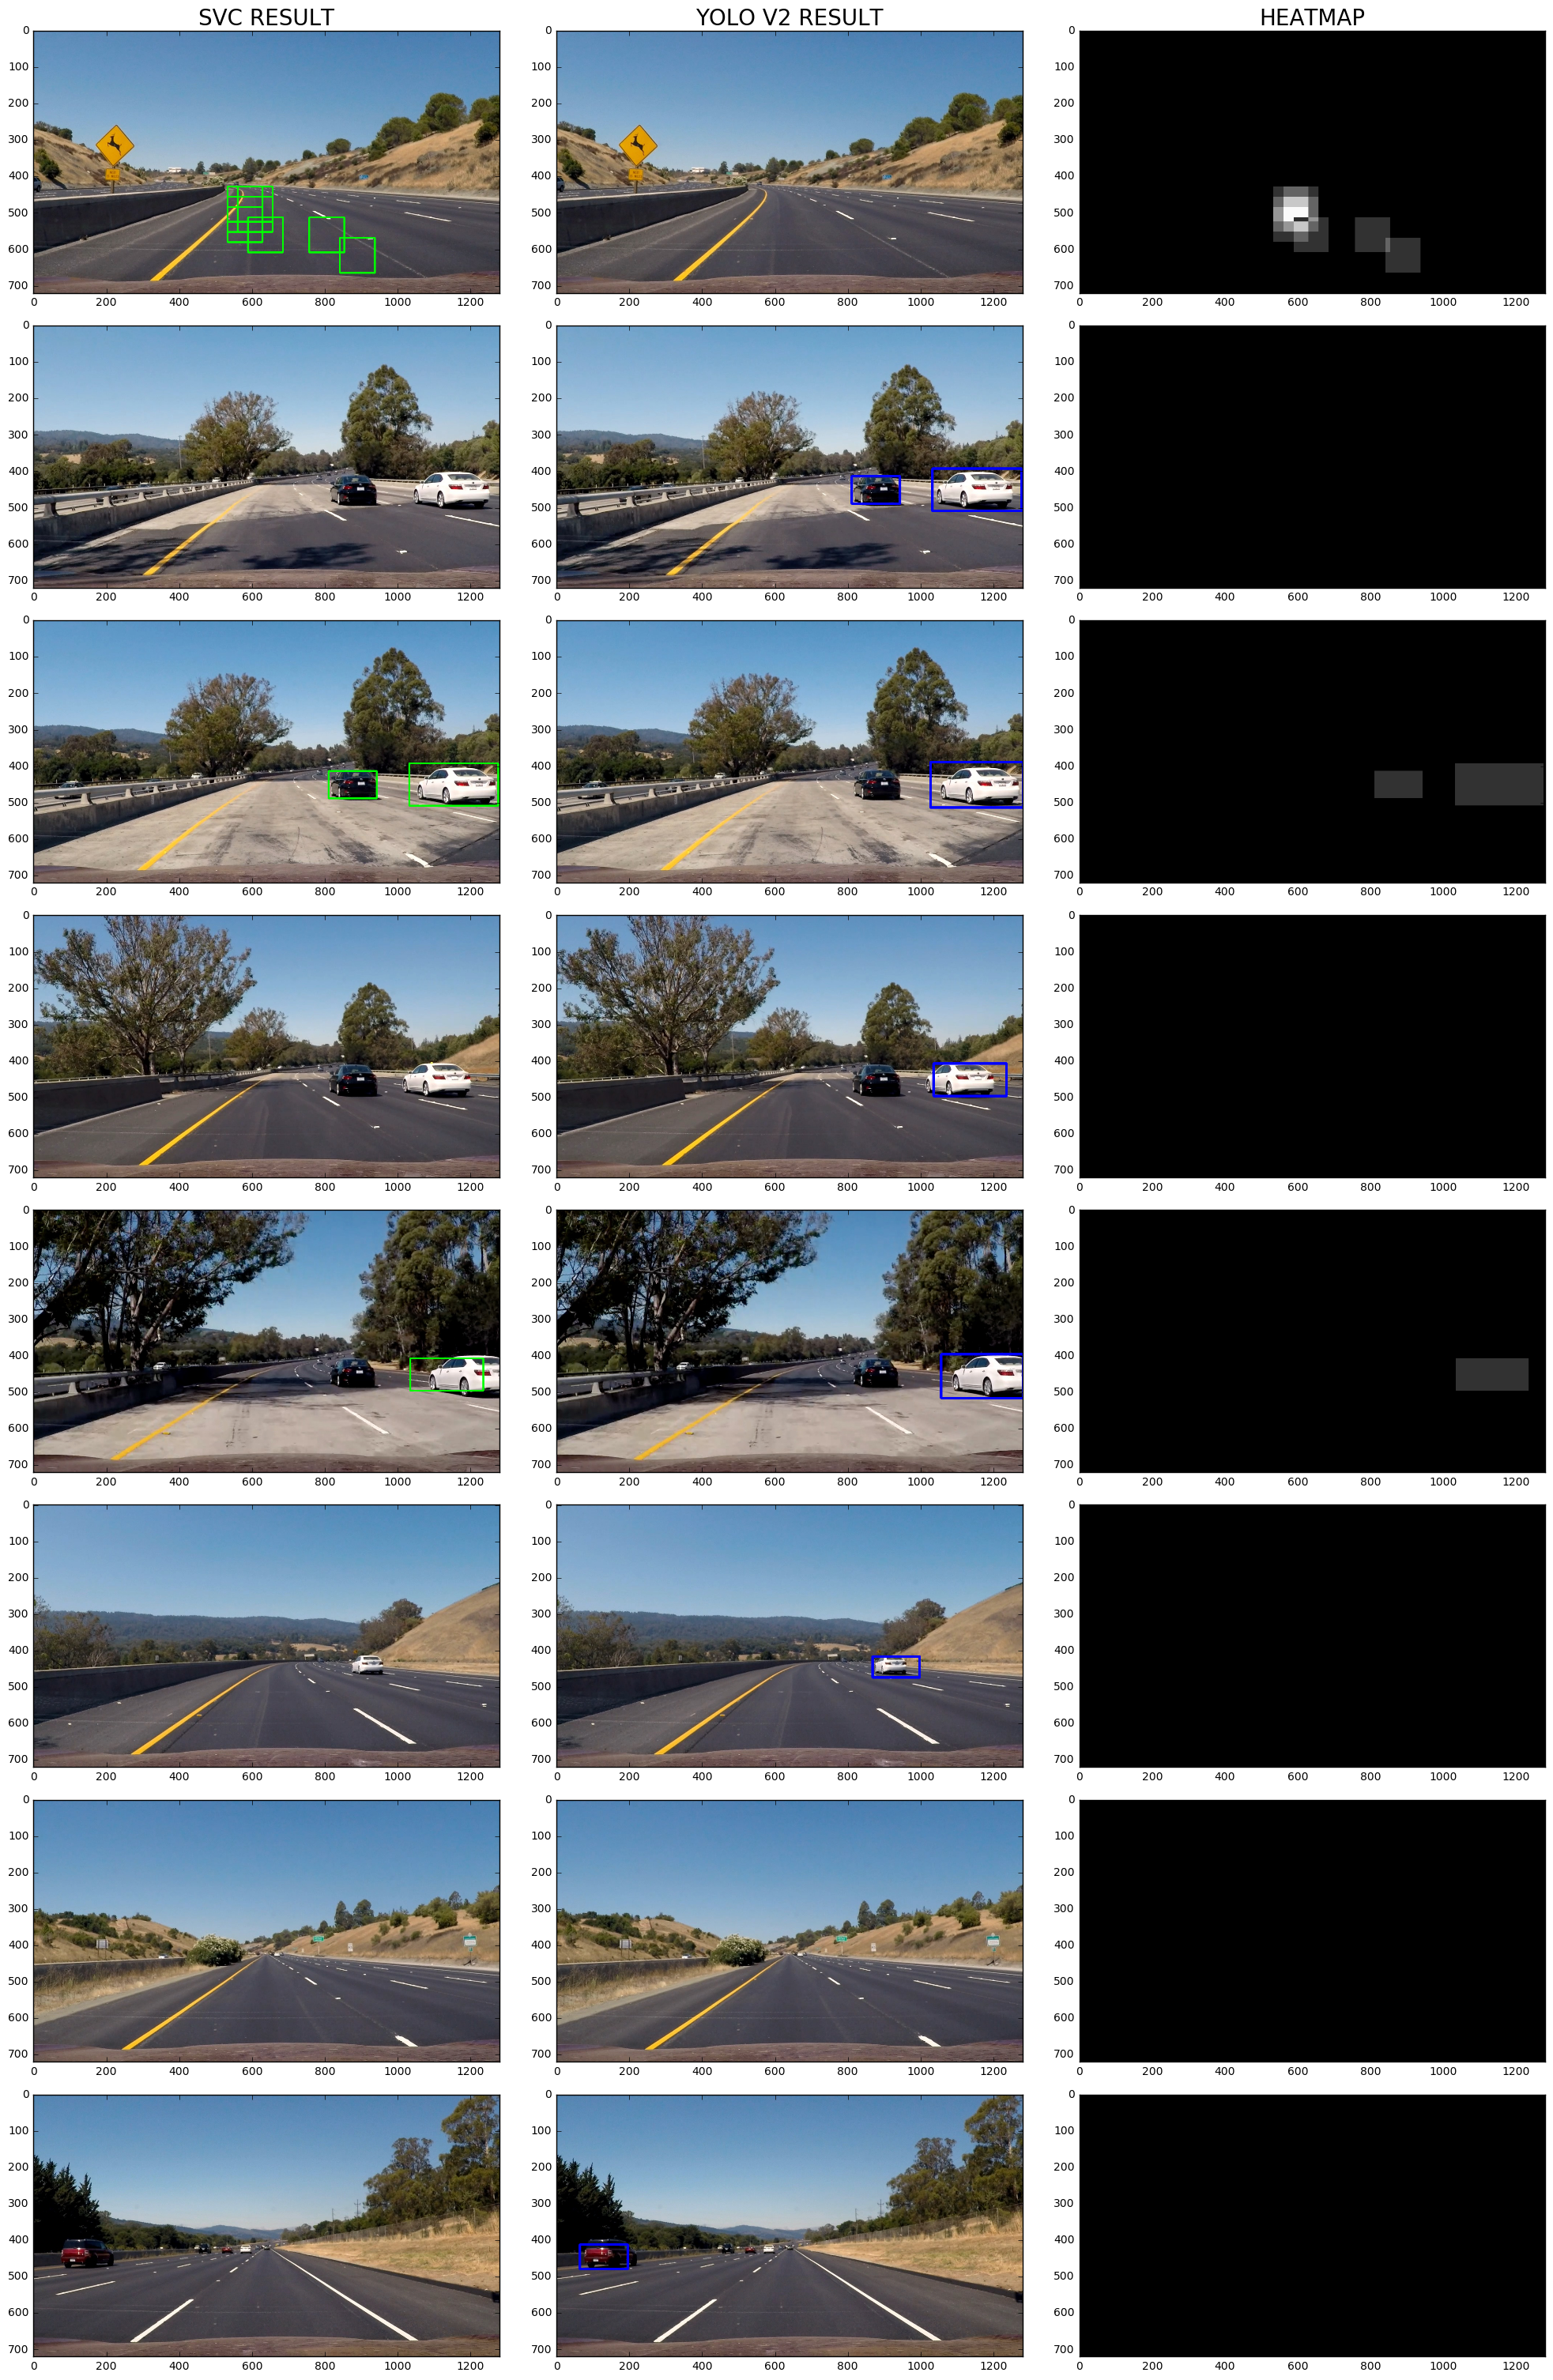

In [35]:
size = len(svc_results)
fg, a = plt.subplots(size, 3, figsize =(20,30))
fg.tight_layout()
a[0, 0].set_title("SVC RESULT", fontsize=20)
a[0, 1].set_title("YOLO V2 RESULT", fontsize=20)
a[0, 2].set_title("HEATMAP", fontsize=20)

for i in range(size):
    a[i, 0].imshow(svc_results[i])
    a[i, 1].imshow(yolo_results[i])
    a[i, 2].imshow(heatmap_results[i])

## Subsampling HOG entire image and 

In [ ]:
dec_thresh = 0.75
window_size = (96, 96)
x_region = [None, None]
y_region = [400, None]
over_lap = (0.7, 0.7)
# Create sliding windows
windows = slide_window(img_size,
                       x_start_stop=x_region,
                       y_start_stop=y_region,
                       xy_window=window_size,
                       xy_overlap=over_lap)

In [ ]:
def process_image(frame):
    global clf
    global windows
    svc_frame = frame.astype(np.float32)

    # Make a heat map of zero - VEHICLE TRACKER
    # heatmap = np.zeros_like(svc_img[:, :, 0])

    # TEST SVC CLASSIFIER
    positive_windows = search_windows(svc_frame, windows, clf, size=(64, 64), decision_threshold=dec_thresh)

    result = draw_boxes(frame, positive_windows)

    return result